In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy.special import softmax, erf
from scipy.optimize import minimize, root

from datetime import datetime

import matplotlib.pyplot as plt

# Andmed

In [2]:
df = pd.read_csv('andmed/spioonid.csv')

df['kuupäev'] = df['kuupäev'].apply(lambda x: datetime.fromisoformat(x))
df['m'] = df['kuupäev'].apply(lambda x: x.timetuple().tm_yday)
df['m'] = df.groupby('m').ngroup()
df['t'] = df['kuupäev'].apply(lambda x: (x - x.replace(hour=0, minute=0, second=0)).total_seconds() / 3600)

df = df.drop(columns=['kuupäev'])
df.head()

,m,t
0,0,14.183333
1,0,17.500000
2,0,18.533333
3,0,21.566667
4,0,22.083333


# Taust
Kirjeldatud meetod põhineb täielikult [Goulding et al.](http://www.cs.nott.ac.uk/~pszgss/goulding2016event_preprint.pdf)

MHPP-d (mittehomogeenset Poissoni protsessi) kirjeldab ajast sõltuv intensiivsus $\lambda(t)$, MHPP on näide loendavast protsessist, mida on võimalik defineerida kahe ajahetke $t_1$ ning $t_2$ vaheliste sündmuste arvu esinemise tõenäosuse kaudu
\begin{align*}
    &P(N(t_1, t_2) = c) = \frac{ \Lambda(t_1, t_2)^c}{c!} e^{- \Lambda(t_1, t_2)} \\
    \text{kus} \quad &\Lambda(t_1, t_2) = \int_{t_1}^{t_2} \lambda(t) dt
\end{align*}
Intensiivsusfunktsiooni kaudu on võimalik avaldada jaotusfunktsioon $F^s(t)$, mis kirjeldab tõenäolist oodatavat aega hetkest $s$ kuni uue sündmuse toimumiseni
\begin{equation*}
    F^s(t) = 1 - e^{\Lambda(s, s + t)}
\end{equation*}
Jaotusfunktsiooni on võimalik kasutada ennustamiseks, lisaks on selle põhjal võimalik leida sündmusrea $\textbf{t}_i$ ühisjaotuse tihedus $f(\textbf{t}_i)$, mis kirjeldab tõenäosust, et rida pärineb sellelt protsessilt.
\begin{equation*}
    f(\textbf{t}_i) = e^{- \Lambda (0 , \tau) } \prod_{j = 1}^n \lambda (t_{ij})
\end{equation*}

# Mudel
Formaalselt võib eelnevat andmestikku kirjeldada sündmusridade hulgana $\mathcal{T} = \{ \textbf{t}_1 , \textbf{t}_2 , \dots , \textbf{t}_m \}$, mille realisatsioonid $\textbf{t}_i = \langle t_{i0} , t_{i1} , \dots , t_{ij} \rangle$ pärinevalt mingilt mittehomogeense Poissoni liitprotsessi alamprotsessilt.

Andmestikku modelleerime $Z$ alamprotsessist koosneva MHPP liitprotsessina, mille alamprotsesside intesiivsused on $K$ kaalutud normaaljaotustiheduste summad 
\begin{align*}
    &\lambda_z(t) = \sum_{k = 1}^K a_{z k} B_k(t) \\
    \text{kus} \quad &B_k(t) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left( - \frac{(t - \mu_k)^2}{2 \sigma^2} \right) \\
    \text{ning} \quad &\mu_k = \frac{(k - 1) \tau}{K - 1} , \qquad \sigma_k = \frac{\tau}{k} 
\end{align*}

In [3]:
K = 25  # number of gaussian variables
m = df['m'].nunique()  # number of event series
Z = 5  # number of parent processes

k = np.arange(1, K + 1)
tau = df['t'].max()
locs = ((k - 1) * tau) / (K - 1)
scales = tau / k

In [4]:
def rate(x, process_weights):
    return np.sum(process_weights * norm.pdf(x, loc=locs, scale=scales))


def joint_pdf(X, process_weights):
    integral = np.sum(process_weights * norm.cdf(tau, loc=locs, scale=scales))
    return np.exp(-integral) * np.prod([rate(x, process_weights) for x in X])

## EM
Toodud ehitusklotside põhjal taandub mudeli loomine kaalude $a_{zk}$ leidmisele. Igale alamprotsessile $N_z(t)$ seame vastavusse segandumis tõenäosuse $p_z$, mis kirjedab võimalust, et mingi sündmusterida hulgas $\mathcal{T}$ pärineb sellelt alamprotsessilt. Eelnevast lähtudes on kogu mudeli tõepära funktsioon
\begin{equation*}
    \mathcal{L}(\theta | \mathcal{T}) = \prod_{i = 1}^m \sum_{z = 1}^Z p_z f_z(\textbf{t}_i)
\end{equation*}
kus $\theta = \langle \lambda_1 , \lambda_2 , \dots , \lambda_Z \rangle$.
Järgnevalt leiame mudeli kaalud iteratiivselt, kasuted EM (expectation maximization) meetodit. Alustades algsete parameetritega $\theta^0$ (siin tähistame $r$-indat iteratsiooni sammu kujul $\theta^r$).

In [5]:
def negative_log_likelihood(weights, weights_shape, mix_probs, orig_probs, orig_probs_shape, data):
    weights = weights.reshape(weights_shape)
    gp = data.groupby('m')['t']
    
    likelihood = 0
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.get_group(i)
        likelihood += orig_probs[(i, z)] * np.log(mix_probs[z] * joint_pdf(t_vec, weights[z]))
    
    return -likelihood  # negate for maximization using 'scipy.optimize.minimize'

### Ooteväärtuse samm
Antud parameetrivektori $\theta^r$ korral leiame iga alamprotsessi jaoks tõenäosused, et sündmuste rida $\textbf{t}_i$ pärineb selleslt alaprotsessilt
\begin{equation*}
    p_{iz}^r = \frac{ e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) }{ \sum_{q = 1}^{Z} e^{- \Lambda_q (0 , \tau)} \prod_{j = 1}^n \lambda_q (t_{ij}) }
\end{equation*}

In [6]:
def expectation_step(data, orig_probs_shape, weights):
    gp = data.groupby('m')['t']
    orig_probs = np.zeros(orig_probs_shape)
    
    for i, z in np.ndindex(orig_probs_shape):
        t_vec = gp.get_group(i)
        
        numerator = joint_pdf(t_vec, weights[z])
        denominator = np.sum([joint_pdf(t_vec, weights[q]) for q in range(Z)])
        
        orig_probs[(i, z)] = numerator / denominator
    
    return orig_probs

### Maksimeerimise samm
Pärinemistõenäosustega leiame uued parameetrite lähendid $\theta^{r + 1}$ suurima logaritm tõepära meetodil
\begin{equation*}
    \theta^{r + 1} = \underset{\theta}{\arg \max} \left[ \sum_{i = 1}^m \sum_{z = 1}^Z p_{iz} \ln \left( p_z e^{- \Lambda_z (0 , \tau) } \prod_{j = 1}^n \lambda_z (t_{ij}) \right) \right]
\end{equation*}
nagu Eesti Kaitseväes kombeks lahendame seda toore jõuga, numbriliselt.

Järgmised hinnangud segandumistõenäosustele leiame lihtsa aritmeetilise keskmisena pärinemistõenäosustest
\begin{equation*}
    p_z^{r + 1} = \frac{1}{n} \sum_{i = 1}^m p_{iz}^r
\end{equation*}

In [7]:
def maximisation_step(data, weights, mix_probs, orig_probs):
    weights_shape = weights.shape
    theta = weights.flatten()
    
    args = (weights_shape, mix_probs, orig_probs, orig_probs.shape, data)
    bounds = ((0, float('inf')) for _ in theta)
    optimize_result = minimize(negative_log_likelihood, theta, args=args, bounds=bounds)
    
    weights = optimize_result['x'].reshape(weights_shape)
    mix_probs = orig_probs.mean(axis=0)
    
    return weights, mix_probs, optimize_result

EM meetodi iteratsioonisamme kordame kuni kindla sammude arvuni või koondumiseni

In [8]:
def em(data, initial_weights, num_series, num_subprocess, max_it=10, error_threshold=1e-5, verbose=False):
    orig_probs = softmax(np.zeros((num_series, num_subprocess), dtype=np.longdouble))
    mixing_probs = np.mean(orig_probs, axis=0)
    
    it, error = 0, error_threshold
    while it < max_it and error >= error_threshold:
        # expectation step
        orig_probs = expectation_step(df, orig_probs.shape, initial_weights)
        
        # maximisation step
        weights, mixing_probs, optimize_result = maximisation_step(df, initial_weights, mixing_probs, orig_probs)
        
        # error and iteration
        error = np.sum(np.abs(weights - initial_weights))
        if verbose:
            print(f'step={it}, error={error}')
        
        initial_weights = weights
        it += 1
        
    return weights

In [9]:
weights = em(df, np.ones((Z, K), dtype=np.longdouble), m, Z)

step=0, error=52.84036240080061
step=1, error=8.60405063000176e-05


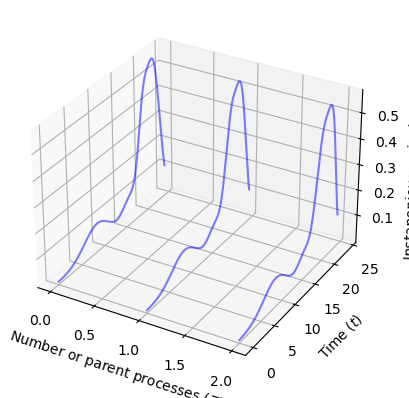

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for z in range(Z):
    time = np.linspace(0, 24, 500)
    rate_z = [rate(t, weights[z]) for t in time]
    
    ax.plot(time, rate_z, zs=z, zdir='x', color='b', alpha=0.5)

ax.set_xlabel('Number or parent processes $(Z)$')
ax.set_ylabel('Time $(t)$')
ax.set_zlabel('Instanenious arrival rate $(\\lambda_z)$')

plt.savefig(f'joonised/mudel_z{Z}_k{K}.png', dpi=100)
plt.show()

## Ennustamine
Ennustamaks järgmise sündmuse toimumishetke sündmuste reas $\textbf{t}$, peame kõigepealt nimetatud sündmuste rea seostama mingi mudeli alamprotsessiga. Soovitud alamprotsessi $\hat{z}$ valime suurima tõepära meetodiga
\begin{equation*}
    \hat{z} = \underset{z \in \{ 1 , 2 , \dots , Z \} }{\arg \max} f_z(\textbf{t})
\end{equation*}

In [12]:
times = df[df['m'] == 7]['t']
z_hat = np.argmax([joint_pdf(times, weights[z]) for z in range(0, Z)])

### Aeg järgmise sündmuseni
Kui võimalik sündmusteseeria tootnud alamprotsess on leitud, leiame aja järgmise sündmuse toimumisena $\pi$, alamprotsessi jaotuse mediaanina
\begin{align*}
    F_z^s(\pi) = 1 - e^{\Lambda_z(s , s + \pi)} &= \frac{1}{2} \\
    \Lambda_z(s , s + \pi) - \ln 2 &= 0
\end{align*}

Tehes asendused ning integreerimse jõuame tulemuseni
\begin{equation*}
    \sum_{k = 1}^K \int_s^{s + \pi} a_{zk} B_k(\pi) dt - \ln 2 =
    \sum_{k = 1}^K \frac{a_{zk}}{2} \left[ \text{erf} \left( \frac{s + \pi - \mu_k}{\sqrt{2} \sigma_k} \right) - \text{erf} \left( \frac{s - \mu_k}{\sqrt{2} \sigma_k} \right) \right] - \ln 2 = 0
\end{equation*}
Kuna kõik muutujad peale $\pi$ on teada, saame lähendi kiiresti leida kasutades numbrilisi meetodeid.

In [18]:
def root_for_preditction(var_pi, from_t, process_weights, quantile=0.5):
    log = np.log(1 / quantile)
    scaled_weights = process_weights / 2
    numerator = from_t - locs
    denominator = np.sqrt(2) * scales
    return np.sum(scaled_weights * (erf((numerator + var_pi) / denominator) - erf(numerator / denominator))) - log

In [21]:
from_time = 16.45
pi_hat = 17

root_result = root(root_for_preditction, pi_hat, args=(from_time, weights[z_hat]))
root_result

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: -1.0118455134354243
       x: [-8.330e+02]
    nfev: 15
    fjac: [[ 1.000e+00]]
       r: [ 0.000e+00]
     qtf: [-1.012e+00]